### Install some requirements

In [ ]:
pip install pyarrow

In [ ]:
pip install seaborn

In [ ]:
pip install jinja2

In [ ]:
pip install jupyter-summarytools

In [234]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from summarytools import dfSummary

### Read Parquet Files

In [239]:
df_log = pd.read_parquet('Parcel Perform_DA_Takehome Exercise\\log_table.pqt', engine='pyarrow')
df_parcel = pd.read_parquet('Parcel Perform_DA_Takehome Exercise\\parcel_table.pqt', engine='pyarrow')

### Quick check data dupllication and missing values

In [240]:
print(df_log.info())
print('######################################')
print('Duplicate?', df_log.duplicated().any())
df_log.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94771 entries, 0 to 94770
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   log_id               94771 non-null  int64 
 1   parcel_id            94771 non-null  int64 
 2   raw_log_description  94771 non-null  object
 3   log_key              94771 non-null  object
 4   log_timestamp        94771 non-null  object
 5   additional_params    94771 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.3+ MB
None
######################################
Duplicate? True


,log_id,parcel_id,raw_log_description,log_key,log_timestamp,additional_params
0,935869563,2928654176,Carrier EDD generated,EDD101,2024-06-04 0:08:08,"{""event_type_master_data_id"": ""EDD101""}"
1,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
2,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
3,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
4,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"


In [241]:
print(df_parcel.info())
print('######################################')
print('Duplicate?', df_parcel.duplicated().any())
df_parcel.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50083 entries, 0 to 50082
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   parcel_id              50083 non-null  int64 
 1   carrier_name           50063 non-null  object
 2   picked_up_date         21594 non-null  object
 3   out_for_delivery_date  49277 non-null  object
 4   first_attempt_date     49616 non-null  object
 5   final_delivery_date    49381 non-null  object
 6   origin_country         50060 non-null  object
 7   destination_country    50055 non-null  object
 8   is_delivered           50083 non-null  bool  
dtypes: bool(1), int64(1), object(7)
memory usage: 3.1+ MB
None
######################################
Duplicate? True


,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered
0,2981186961,Initech,2024-06-20 7:00:11,2024-06-20 20:57:51,2024-06-20 22:18:27,2024-06-20 22:18:27,Australia,Australia,True
1,2948380100,Initech,2024-06-08 6:00:06,2024-06-18 0:12:26,2024-06-18 3:33:55,2024-06-18 3:33:55,Australia,Australia,True
2,2948508927,Initech,2024-06-21 1:45:00,2024-06-21 21:53:58,2024-06-21 23:42:15,2024-06-21 23:42:15,Australia,Australia,True
3,2941258771,Initech,None,2024-06-12 0:06:19,2024-06-12 1:18:39,2024-06-12 1:18:39,Australia,Australia,True
4,2980427311,Massive,None,2024-06-22 23:09:38,2024-06-23 2:43:15,2024-06-23 2:43:15,Australia,Australia,True


### Realized that we got a lot of duplication, so drop it. About null value, as long as parcel_id is not null, the rest is still worth to keep for more exploration 

In [242]:
df_log = df_log.drop_duplicates()
df_parcel = df_parcel.drop_duplicates()

print(df_log.info())
print(df_parcel.info())

<class 'pandas.core.frame.DataFrame'>
Index: 53404 entries, 0 to 94770
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   log_id               53404 non-null  int64 
 1   parcel_id            53404 non-null  int64 
 2   raw_log_description  53404 non-null  object
 3   log_key              53404 non-null  object
 4   log_timestamp        53404 non-null  object
 5   additional_params    53404 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8757 entries, 0 to 50069
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   parcel_id              8757 non-null   int64 
 1   carrier_name           8737 non-null   object
 2   picked_up_date         4112 non-null   object
 3   out_for_delivery_date  8638 non-null   object
 4   first_attempt_date     8684 non-null 

### Using EDA library for more convenience in quick check data reliability 

In [244]:
dfSummary(df_log)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,log_id[int64],Mean (sd) : -1609648151.6 (1219934790.9)min < med < max:-2147483648.0 < -2147483648.0 < 1430976400.0IQR (CV) : 0.0 (-1.3),"8,713 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAflJREFUeJzt2EFOwkAYhuEZRQIuZtI06SW8QQ/hYTmCi56AG7AjaZo2II3Qjhl3LlAYQP3M+2zhnzbpmxmKDSEY4K+7++0bAE4x+e4L1tq5MWZq0ryFEHaJs8BpocZI8zx/ds5lJkHXdY21dkGsuPWOOo2RlmW589735yzctu2sqqqsruu4GxMqbnv0RzHSoiheE9aPPxuAi/EyBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmT374B/B/W2rkxZpo4/hZC2B37kFBxtUjzPH92zmUp813XNdbaxbFYCRXXMo2RlmW589735wy2bTurqiqr6zruxoSKmx7dbhzHB+99UxTFa8J8vPZRhIqrHN37/X42DMNT3/cvxpiUUL9EqLj46I5Wq1W2XC4fD4fDvbkBQsUnMdKUo7tpmi+P7kvxPyokTE59Kzt34TgzDENc31lrk24OP8qN4zhJedbRZrP5mNtut7P1ev14zuwp13wHw4V2KpSf4NoAAAAASUVORK5CYII="">",0(0.0%)
2,parcel_id[int64],Mean (sd) : 2959269289.0 (24012888.3)min < med < max:2928654176.0 < 2953622932.0 < 3009728867.0IQR (CV) : 47929801.0 (123.2),"8,707 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAoVJREFUeJzt3UFu2kAYhuGZYoILyBaigh0XqNQFSw7Rw/YIQeIEuQE7JMsC4cbCGFeO1F3VgI3JfJP3WccOi1eDwb8HW1WVAVz35aNfAHCN4L0/sNZ+NcY8mWZOVVW9NjwWuC7UOtLpdPoziqKJaeBwOKTW2l/Eiq5X1Kc60tVq9RrHcX7Liff7fbjZbCZJktSrMaGi27f+Wh3pbDb73eD89WUD0BofpiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUOHPlj54nJa7J3q7gyKhOqTt7ok+76BIqG5pvHui7zsoEqqDWuye6O0OinyYggRChQRChQRChQRChQRChQS+nvJMWZZ9Y0xkrfXqrhaheiTLsn5RFD8Wi0Wv1+vlPt3VIlSPnE6nIAzD4XK5zOfzeerTXS1vQ/3Mwx2j0ci73wULHL5eahwLwx3+CVy9XmoZC8MdnglcvF76G8t6vZ4lSfLNWnu48fDocrn04zhOGe7wQ+Dq9VKbFbkoirAsy+95nj8bY5qGCoc4+2GqzYq83W4nLy8vw/P53OvuFeKRnA21zYqcpilv257hFiokECokECokECokECokECokOP/1FB7no2YzrkGocGE2412EirvNZnQ5yEOouNcsa62zO4KE6tbQ9tvUlxFVdvi8FqHeWZuhbeWpr6zj57UI9f6rQzQej2er1epw69C28tTXqePntQi1o1nYwWDw/BmnvkYdPa9FqP/ALKx7CPU/mIV1B7dQ4c+KWl/s3nri4/H4dkyWZeFutxs+8njV/636uk3L46/p6w9mJbuRrOzt9wAAAABJRU5ErkJggg=="">",0(0.0%)
3,raw_log_description[object],1. Change in Carrier EDD2. Carrier EDD generated,"44,692 (83.7%)8,712 (16.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAASpJREFUeJzt2z1qw0AUReGZIEzSSBiBFqNFeLFehHYjglTEwc2EKbyEd3gO5yvcTuHjX+bW1lqRCLWU8lVKuSCnKbNna+0RecAwz/NtHMdr5CHK7zzP71rrPTK4oYe2rutjmqbfqEOU23Ecn9u2Xfd9759wcbH1hx7asiw/UYfoLfSvU6E+og+QXoxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTZnhdnuOOVDbU8z/068D9liZxeU559Q76DiHyDAcvwgYv1SmfKNQ7W/irRvkhUz5iJqb8wqd81ExM+VFTPn/pyj91xTE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxN/2fK50xQ6JSPmIkpPwcvKpQ/Cltq3zMouvQAAAAASUVORK5CYII="">",0(0.0%)
4,log_key[object],1. EDD1022. EDD101,"44,692 (83.7%)8,712 (16.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAASpJREFUeJzt2z1qw0AUReGZIEzSSBiBFqNFeLFehHYjglTEwc2EKbyEd3gO5yvcTuHjX+bW1lqRCLWU8lVKuSCnKbNna+0RecAwz/NtHMdr5CHK7zzP71rrPTK4oYe2rutjmqbfqEOU23Ecn9u2Xfd9759wcbH1hx7asiw/UYfoLfSvU6E+og+QXoxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTZnhdnuOOVDbU8z/068D9liZxeU559Q76DiHyDAcvwgYv1SmfKNQ7W/irRvkhUz5iJqb8wqd81ExM+VFTPn/pyj91xTE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxN/2fK50xQ6JSPmIkpPwcvKpQ/Cltq3zMouvQAAAAASUVORK5CYII="">",0(0.0%)
5,log_timestamp[object],1. 2024-06-05 17:06:262. 2024-06-05 18:26:173. 2024-06-12 8:10:594. 2024-06-04 19:02

### Noted that we some weird in there:
### - ~8k7 log_id and parcel_id but log_timestamp still have more than 53k
### - Negative log_id appear in stats and median still shows the negative, left skew distribution, which means special cases, maybe
### - For those EDD102 log_key, one log_id has many log_timestamp as data shows below. Should be the latest one for each log_id

In [245]:
df_log[df_log['log_id'] < 0].head(10)

,log_id,parcel_id,raw_log_description,log_key,log_timestamp,additional_params
45,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 13:15:55,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
46,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 14:11:14,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
47,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 15:08:06,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
48,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 16:03:52,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
49,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 17:52:25,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
50,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 18:52:49,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
51,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 19:48:07,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
52,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-02 23:27:18,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
53,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-03 0:22:38,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."
54,-2147483648,2928669922,Change in Carrier EDD,EDD102,2024-06-03 3:06:06,"{""event_type_master_data_id"": ""EDD102"", ""new_p..."


In [246]:
dfSummary(df_parcel)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,parcel_id[int64],Mean (sd) : 2962837776.7 (79805519.5)min < med < max:1372063139.0 < 2961442366.0 < 3009728867.0IQR (CV) : 44304820.0 (37.1),"8,727 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAVlJREFUeJzt101qWzEYQNGnYtJ0YhMMXowX0cVmEd6NKc+DpnTgV94CTB2T/lw4Zyp9oMFFSGNZlgn+d5/+9QHgHpu7dsEdxhhfpml6mh7zc1mWt1uLQuXDIt3v91+32+3LI/OXy+XbGOP1VqxC5aM8rZEej8e33W734z2D8zw/n06nl/P5vN7GQuXPWyM9HA7fHxhdnw03+UyRIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJAiVBKGSIFQShEqCUEkQKglCJUGoJGx+t2GM8TxN0+e/cxzCttfrdTPP89rLu9wz8wuFTCkWTXBxuQAAAABJRU5ErkJggg=="">",0(0.0%)
2,carrier_name[object],1. Initech2. Globex3. Massive4. UNKNOWN5. None,"8,375 (95.6%)236 (2.7%)96 (1.1%)30 (0.3%)20 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAkpJREFUeJzt3UFKG2EYgOF/JLTNRhHBI7Q7D+AhetgewgO47B2k6KKp3aQMtYtiqoUwbyA+zyIEsphZvMw/E/4vmbbb7YDCSXIUEBslsZGZxhjrMca77pAcuZ/b7Xaz64PVxcXF59PT0/P+nDhGDw8P36Zp+rIruNUc2vX19ebs7OzHYU6PY3F/f//h5ubm/O7ubl4pn8c2v8yhXV5efj/IGXJs5tuynTwgkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkVn92RrSHZJj9VpHq3mz27wH6aWtIfC/5p7m3bq7PrMtnGxb+GRulIoHBDK7ltF/XgZhH8+mq16ajoF9/DVd9dp0DOxj13SVr0BYhAcEMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2DjNdZcqKJT2brnppOgb2YVs4GdNVZDwgcJBl1PJJM11lqoqlncyhXV1djadxPj/DwLL3bOv1+nG5Q8BvHhDIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNhoY9tsNu+7Q/JWncybJm9vb01VsTjbwsmYriK/sg1XNZKBl/mNYReSgRfDLhR8z0ZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZstP9d9fTeZBWLMoNAxnQVGfdsZE6mafo0TZM/tSW5sn0cY/itDxZnGSUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM20ti+jjEeu0PyVhl4IWMZJSM2MmJjVH4BUW+vHyLPgfkAAAAASUVORK5CYII="">",20(0.2%)
3,picked_up_date[object],1. None2. 2024-06-11 5:54:003. 2024-06-11 5:39:004. 2024-06-12 23:35:005. 2024-06-10 0:07:006. 2024-06-11 6:14:007. 2024-06-22 8:16:588. 2024-06-08 8:23:089. 2024-06-22 8:16:4610. 2024-06-12 8:28:3911. other,"4,645 (53.0%)14 (0.2%)10 (0.1%)10 (0.1%)9 (0.1%)9 (0.1%)9 (0.1%)9 (0.1%)9 (0.1%)8 (0.1%)4,025 (46.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA9lJREFUeJzt3E2KWlsUgNFzg+SnoxSCQ3hvDg4ig80gHETmIEEbqbx0fJx2qEog5rPKrNWwVXgv8uH2wtm1XC6XAYU3yVVAbJTERkZsZMRGRmxkxEZGbGTERmYZY3wYY7ztLnm3vl8ul8db38RLttputx/X6/XDrW/ktTufz1+WZfkkuKetZmj7/f5xs9l8e+bveMbpdHp/OBwejsfjnBBie8JqvszQdrvd16f+iF8yf47wDA8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGe8RonsfqLnl/fH6/ZjVPmM6Df85j/Z75Oc6j4be+j5fMDsL12EH4icW/zKLiAYHMm2VZ/l2WxQ9ckm+2f8YY7/78pfjbGaNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbKSxfR5j/Nddkr+VHQQyxigZsZGx8ELGwgsZY5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYyFFzIWXsgYo2TERkZsZGxXkbFdRcYYJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY7uKjO0qMsYoGbGRsfBCxsILGWOUjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MhRcyFl7IGKNkxEbGwgsZCy9kjFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI2O7ioztKjLGKBmxkbFdRcZ2FRljlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjIUXMhZeyBijZMRGxsILGQsvZIxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyFl7IWHghY4ySERsZsZGxXUXGdhUZY5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYztKjK2q8gYo2TERsbCCxkLL2SMUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MhZeyFh4IWOMklnGGB/GGG+7S74q3y+Xy+Otb+JerLbb7cf1ev1w6xt5ic7n85dlWT4J7jpWM7T9fv+42Wy+Xek978LpdHp/OBwejsfj/NYX2xWs5ssMbbfbfb3GG96Z+RODK/GAQEZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERnvqYx6n6S75OvhMrm81DwjOc1uO0/xofjbztO6t7+NeOBb+PMfCr8h2FRkPCGTERkZsZMRGRmxkxEZGbGTERkZsjMr/l+SeNJ4vtDkAAAAASUVORK5CYII="">","4,645(53.0%)"
4

### Key Highlights:
### - More than 99% parcel is delivered and almost in Australia with ~96%
### - More than 95% parcel come from Initech
### - 53% booking doesnt have pick up time

### From those thing from quick EDA Summary, do some data processing and feature engineering 

In [247]:

# just for sure, a back up df during the process of data cleaning
df_log_after_remove_duplicate = df_log.copy()

# due to one log_id has many log_timestamp, we need to remove the duplicate log_timestamp by keeping the last one
df_log_after_remove_duplicate = df_log_after_remove_duplicate.sort_values(by="log_timestamp").groupby("parcel_id").last().reset_index()

# convert the additional_params from string to dictionary format and expand it to columns for more analysis later
df_log_after_remove_duplicate['additional_params'] = df_log_after_remove_duplicate['additional_params'].apply(json.loads) 

df_log_expanded = df_log_after_remove_duplicate['additional_params'].apply(pd.Series)

df_log_final = pd.concat([df_log_after_remove_duplicate, df_log_expanded], axis=1).drop(columns=['additional_params'])

# convert the log_timestamp to datetime format
time_columns = [
    'new_parcel_expected_time_first_start', 'new_parcel_expected_time_latest_start',
    'old_parcel_expected_time_first_start', 'old_parcel_expected_time_latest_start',
    'new_parcel_expected_time_first_end', 'old_parcel_expected_time_first_end'
]

for col in time_columns:
    df_log_final[col] = pd.to_datetime(df_log_final[col], errors='coerce', utc=True).dt.tz_convert(None)


# check the missing value in the dataset and fill it with the latest start time if the first start time is missing
df_log_final["new_parcel_expected_time_first_start"].fillna(df_log_final["new_parcel_expected_time_latest_start"], inplace=True)
df_log_final["old_parcel_expected_time_first_start"].fillna(df_log_final["old_parcel_expected_time_latest_start"], inplace=True)

# calculate the estimated delivery date based on the first start and first end time of the parcel
df_log_final["new_estimated_delivery_date"] = ((df_log_final["new_parcel_expected_time_first_end"] - df_log_final["new_parcel_expected_time_first_start"]).dt.total_seconds() // 3600 / 24).round(1)
df_log_final["old_estimated_delivery_date"] = ((df_log_final["old_parcel_expected_time_first_end"] - df_log_final["old_parcel_expected_time_first_start"]).dt.total_seconds() // 3600 / 24).round(1)

print(df_log_final.info())
df_log_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8707 entries, 0 to 8706
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   parcel_id                              8707 non-null   int64         
 1   log_id                                 8707 non-null   int64         
 2   raw_log_description                    8707 non-null   object        
 3   log_key                                8707 non-null   object        
 4   log_timestamp                          8707 non-null   object        
 5   event_type_master_data_id              8707 non-null   object        
 6   new_parcel_expected_time_first_end     1056 non-null   datetime64[ns]
 7   old_parcel_expected_time_first_end     1507 non-null   datetime64[ns]
 8   new_parcel_expected_time_first_start   2658 non-null   datetime64[ns]
 9   old_parcel_expected_time_first_start   3125 non-null   datetime

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10076\192266109.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_log_final["new_parcel_expected_time_first_start"].fillna(df_log_final["new_parcel_expected_time_latest_start"], inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10076\192266109.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the int

,parcel_id,log_id,raw_log_description,log_key,log_timestamp,event_type_master_data_id,new_parcel_expected_time_first_end,old_parcel_expected_time_first_end,new_parcel_expected_time_first_start,old_parcel_expected_time_first_start,new_parcel_expected_time_latest_start,old_parcel_expected_time_latest_start,__trigger_source,__trigger_request_id,new_estimated_delivery_date,old_estimated_delivery_date
0,2928654176,935869563,Carrier EDD generated,EDD101,2024-06-04 0:08:08,EDD101,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN
1,2928669922,-2147483648,Change in Carrier EDD,EDD102,2024-06-04 9:35:52,EDD102,2024-06-08 23:59:59,2024-06-08 23:59:59,2024-06-05,2024-06-05 23:59:59,NaT,NaT,NaN,NaN,4.0,3.0
2,2928713073,-2147483648,Change in Carrier EDD,EDD102,2024-06-08 3:05:26,EDD102,2024-06-14 23:59:59,2024-06-09 13:59:59,2024-06-09,2024-06-06 14:00:00,NaT,NaT,NaN,NaN,6.0,3.0
3,2928714933,-2147483648,Change in Carrier EDD,EDD102,2024-06-05 8:14:37,EDD102,NaT,2024-06-08 13:59:59,NaT,2024-06-05 14:00:00,NaT,NaT,NaN,NaN,NaN,3.0
4,2928718349,-2147483648,Change in Carrier EDD,EDD102,2024-06-06 7:36:02,EDD102,NaT,2024-06-08 13:59:59,NaT,2024-06-05 14:00:00,NaT,NaT,NaN,NaN,NaN,3.0


### Merge them 

In [248]:
df_parcel_log_merge = pd.merge(df_parcel, df_log_final, how='left', on='parcel_id')

# convert the time columns to datetime format again
time_columns_parcel = [
    'picked_up_date', 'first_attempt_date', 'final_delivery_date', 'out_for_delivery_date'
]

for col in time_columns_parcel:
    df_parcel_log_merge[col] = pd.to_datetime(df_parcel_log_merge[col], errors='coerce', utc=True).dt.tz_convert(None)

# calculate the transit time of the parcel based on the picked up date and final delivery date
df_parcel_log_merge['transit_time'] = (df_parcel_log_merge['final_delivery_date'] - df_parcel_log_merge['picked_up_date']).dt.total_seconds() // 3600 / 24

# conver the log_timestamp to weekday for more analysis later
df_parcel_log_merge['log_timestamp'] = pd.to_datetime(df_parcel_log_merge['log_timestamp'])
df_parcel_log_merge['weekday'] = df_parcel_log_merge['log_timestamp'].dt.day_name()

# fill the missing value with 0
df_parcel_log_merge = df_parcel_log_merge.fillna(0)

df_parcel_log_merge.head()

,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered,log_id,...,new_parcel_expected_time_first_start,old_parcel_expected_time_first_start,new_parcel_expected_time_latest_start,old_parcel_expected_time_latest_start,__trigger_source,__trigger_request_id,new_estimated_delivery_date,old_estimated_delivery_date,transit_time,weekday
0,2981186961,Initech,2024-06-20 07:00:11,2024-06-20 20:57:51,2024-06-20 22:18:27,2024-06-20 22:18:27,Australia,Australia,True,1.229159e+09,...,0,0,0,0,0,0,0.0,0.0,0.625,Thursday
1,2948380100,Initech,2024-06-08 06:00:06,2024-06-18 00:12:26,2024-06-18 03:33:55,2024-06-18 03:33:55,Australia,Australia,True,-2.147484e+09,...,2024-06-19 00:00:00,2024-06-14 14:00:00,0,0,0,0,4.0,5.0,9.875,Monday
2,2948508927,Initech,2024-06-21 01:45:00,2024-06-21 21:53:58,2024-06-21 23:42:15,2024-06-21 23:42:15,Australia,Australia,True,-2.147484e+09,...,2024-06-22 00:00:00,2024-06-20 14:00:00,0,0,0,0,0.0,0.0,0.875,Friday
3,2941258771,Initech,0,2024-06-12 00:06:19,2024-06-12 01:18:39,2024-06-12 01:18:39,Australia,Australia,True,-2.147484e+09,...,2024-06-12 00:00:00,2024-06-12 23:59:59,0,0,0,0,4.0,3.0,0.000,Tuesday
4,2980427311,Massive,0,2024-06-22 23:09:38,2024-06-23 02:43:15,2024-06-23 02:43:15,Australia,Australia,True,-2.147484e+09,...,2024-06-23 13:59:59.999000,2024-06-23 13:59:59,2024-06-23 13:59:59.999000,2024-06-23 13:59:59,0,0,0.0,0.0,0.000,Saturday


### Quick check some stats last time after preprocessing

In [249]:
df_parcel_log_merge.describe(include='all')

,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered,log_id,...,new_parcel_expected_time_first_start,old_parcel_expected_time_first_start,new_parcel_expected_time_latest_start,old_parcel_expected_time_latest_start,__trigger_source,__trigger_request_id,new_estimated_delivery_date,old_estimated_delivery_date,transit_time,weekday
count,8.757000e+03,8757,8757.0,8757.0,8757.0,8757.0,8757,8757,8757,8.757000e+03,...,8757.0,8757.0,8757.0,8757.0,8757.0,8757.0,8757.000000,8757.000000,8757.000000,8757
unique,NaN,5,3577.0,8490.0,8613.0,8594.0,16,4,2,NaN,...,71.0,76.0,22.0,49.0,2.0,161.0,NaN,NaN,NaN,8
top,NaN,Initech,0.0,0.0,0.0,0.0,Australia,Australia,True,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,Thursday
freq,NaN,8375,4645.0,119.0,73.0,94.0,8426,8495,8683,NaN,...,6094.0,5627.0,8667.0,8664.0,8594.0,8594.0,NaN,NaN,NaN,2741
mean,2.962838e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.279438e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,0.495147,0.635948,1.697452,NaN
std,7.980552e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.602639e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,1.413286,1.492306,2.596711,NaN
min,1.372063e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.147484e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.333333,NaN
25%,2.942681e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.147484e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
50%,2.961442e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.019375e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
75%,2.986986e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.251349e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.875000,NaN


#### => some weird on transit_time < 0. Noted for excl later

## Part 2 Anwser

In [251]:

# calculate the difference between new and old estimated delivery dates. abs() is used to get the absolute value to avoid both positive and negative differences cancelling each other out.
df_parcel_log_merge['edd_change'] = (df_parcel_log_merge['new_estimated_delivery_date'] - df_parcel_log_merge['old_estimated_delivery_date']).abs()

# calculate delivery date gap between actual and estimated delivery date, still using abs() to avoid both positive and negative differences cancelling each other out.
if df_parcel_log_merge['new_estimated_delivery_date'] is not None:
    df_parcel_log_merge['delivery_date_gap'] = (df_parcel_log_merge['transit_time'] - df_parcel_log_merge['new_estimated_delivery_date']).abs()
else:
    df_parcel_log_merge['delivery_date_gap'] = (df_parcel_log_merge['transit_time'] - df_parcel_log_merge['old_estimated_delivery_date']).abs()


# calculate the on-time delivery rate based on the delivery date gap within 1 day tolerance, excluding the 0 gap as it is considered on-time
df_parcel_log_merge['is_on_time'] =  (df_parcel_log_merge['delivery_date_gap'] <= 1) & (df_parcel_log_merge['delivery_date_gap'] > 0)

# calculate the first attempt success rate based on the first attempt date and final delivery date
df_parcel_log_merge['delivered_on_first_attempt'] = ((df_parcel_log_merge['first_attempt_date'] == df_parcel_log_merge['final_delivery_date']) 
                                                            & (df_parcel_log_merge['first_attempt_date'] != 0)
                                                            & (df_parcel_log_merge['final_delivery_date'] != 0))

# Calculate on-time delivery metrics by carrier
edd_accuracy = df_parcel_log_merge.groupby('carrier_name').agg({
    'is_on_time': 'mean',
}).round(3)

# Rename columns for clarity
edd_accuracy.columns = ['On Time Rate'] 

print("\nEDD Accuracy:")
edd_accuracy[~edd_accuracy.index.isin([0, 'UNKNOWN'])] # exclude the missing carrier and unknown carrier


EDD Accuracy:


,On Time Rate
carrier_name,
Globex,0.492
Initech,0.089
Massive,0.073


#### - Based on those metrics, Globex has the highest accuracy on EDD with 49.2%


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10076\2611972511.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_df[~filtered_df.index.isin([0, 'UNKNOWN'])], x='weekday', y='delivery_date_gap', palette='viridis') # exclude the missing carrier and unknown carrier


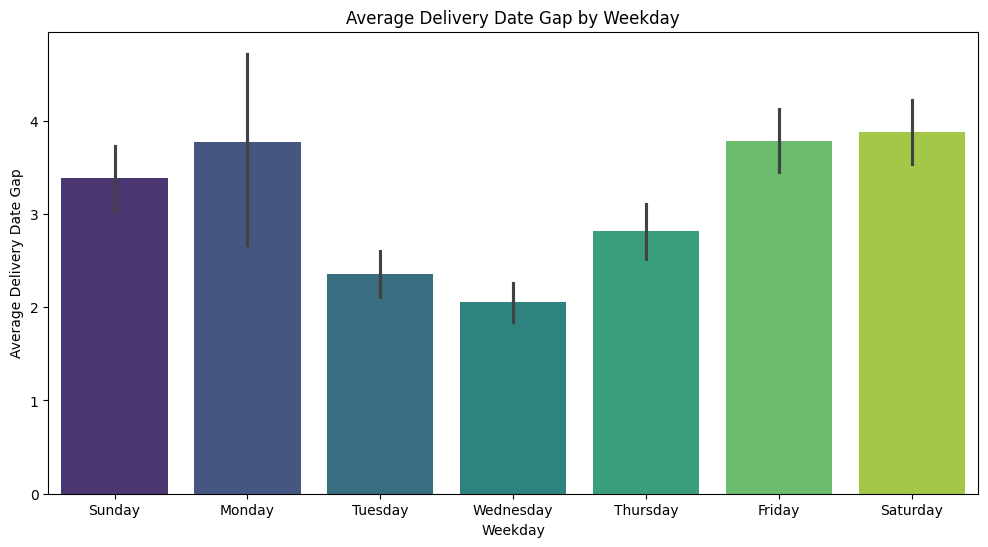

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10076\2611972511.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_df[~filtered_df.index.isin([0, 'UNKNOWN'])], x='weekday', y='edd_change', palette='viridis') # exclude the missing carrier and unknown carrier


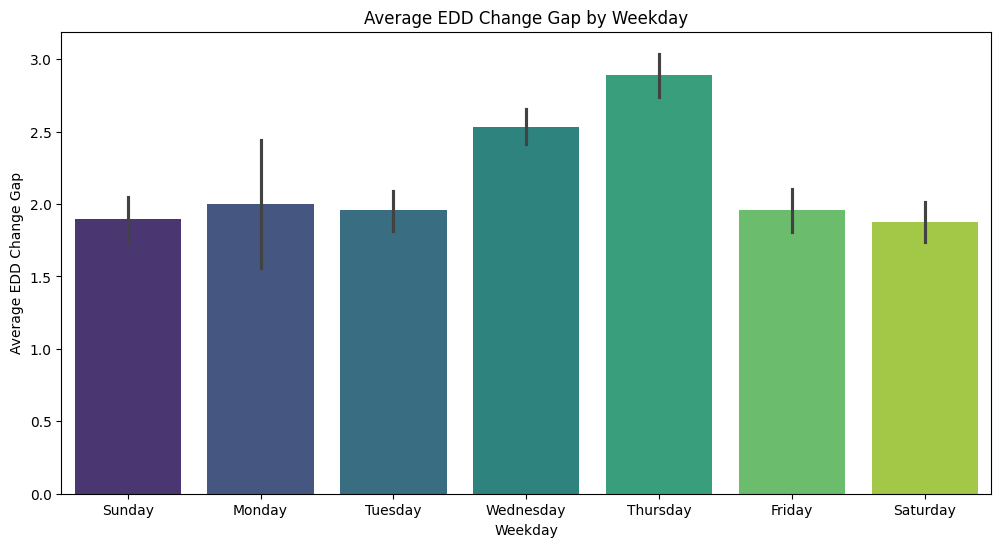

In [252]:

# Ensure 'weekday' column is ordered correctly
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_parcel_log_merge['weekday'] = pd.Categorical(df_parcel_log_merge['weekday'], categories=weekday_order, ordered=True)


filtered_df = df_parcel_log_merge[df_parcel_log_merge['edd_change'] != 0]

# Delivery Date Gap by Weekday
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df[~filtered_df.index.isin([0, 'UNKNOWN'])], x='weekday', y='delivery_date_gap', palette='viridis') # exclude the missing carrier and unknown carrier
plt.title('Average Delivery Date Gap by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Delivery Date Gap')
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df[~filtered_df.index.isin([0, 'UNKNOWN'])], x='weekday', y='edd_change', palette='viridis') # exclude the missing carrier and unknown carrier
plt.title('Average EDD Change Gap by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average EDD Change Gap')
plt.show()


#### => Delievery Gap Date has a low gap on midweek days and a high on weekends, which may come from traffic interference. That's also why EDD tends to be highly predicted on midweek days.

## Part 3

In [253]:
# Calculate on-time delivery metrics by carrier
metrics_df = df_parcel_log_merge[~df_parcel_log_merge['carrier_name'].isin([0, 'UNKNOWN'])]

carrier_performance = metrics_df.groupby('carrier_name').agg({
    'parcel_id': 'count',
    'is_delivered': 'mean',
    'delivery_date_gap': lambda x: x[x != 0].mean(),
    'is_on_time': 'mean',
    'transit_time': lambda x: x[x > 0].mean(),
    'edd_change': 'mean',
    'delivered_on_first_attempt': 'mean'
}).round(3)

# Rename columns for clarity
carrier_performance.columns = ['Total Deliveries', 'Delivered (%)', 'Avg Delivery Date Gap (days)', 'On Time Rate (EDD accuracy %)', 'Avg Transit Time (days)', 'Avg EDD Change (days)', 'First Attempt Success Rate (%)'] 

print("\nCarrier Performance Metrics:")
carrier_performance.sort_values('Total Deliveries', ascending=False)


Carrier Performance Metrics:


,Total Deliveries,Delivered (%),Avg Delivery Date Gap (days),On Time Rate (EDD accuracy %),Avg Transit Time (days),Avg EDD Change (days),First Attempt Success Rate (%)
carrier_name,,,,,,,
Initech,8375,0.992,3.534,0.089,3.743,0.350,0.901
Globex,236,0.966,2.227,0.492,2.227,0.000,0.890
Massive,96,0.979,3.634,0.073,3.881,0.021,0.885


#### Overall Summary from Carrier Performance Metrics
#### - Initech has the highest volume of deliveries with 8375 but struggles with on-time delivery accuracy with ~8.9%.
#### - Globex performs the best in terms of on-time delivery accuracy with ~49.2% and has a high first attempt success rate ~89%.
#### - Massive has the highest average delivery date gap ~3.6 days and the lowest on-time delivery accuracy ~7.3%.

## Some unexpected results

#### 1. The transit time should not be negative, but there are some negative values in the dataset.

In [254]:
df_parcel_log_merge[df_parcel_log_merge['transit_time'] < 0]

,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered,log_id,...,__trigger_source,__trigger_request_id,new_estimated_delivery_date,old_estimated_delivery_date,transit_time,weekday,edd_change,delivery_date_gap,is_on_time,delivered_on_first_attempt
291,2932678222,Initech,2024-06-05 05:13:23,2024-06-01 05:11:28,2024-06-05 03:39:46,2024-06-05 03:39:46,Australia,Australia,True,-2.147484e+09,...,0,0,0.0,3.0,-0.083333,Wednesday,3.0,0.083333,True,True
1694,2936901599,Initech,2024-06-07 05:53:08,2024-06-06 23:46:08,2024-06-07 02:16:30,2024-06-07 02:16:30,Australia,Australia,True,-2.147484e+09,...,0,0,0.0,0.0,-0.166667,Thursday,0.0,0.166667,True,True
5282,2948853046,Initech,2024-06-09 08:35:21,2024-06-08 23:29:42,2024-06-09 00:47:07,2024-06-09 00:47:07,Australia,Australia,True,1.019934e+09,...,0,0,0.0,0.0,-0.333333,Saturday,0.0,0.333333,True,True
5298,2936936027,Initech,2024-06-07 05:53:08,2024-06-06 21:54:08,2024-06-07 02:56:26,2024-06-07 02:56:26,Australia,Australia,True,9.764703e+08,...,0,0,0.0,0.0,-0.125000,Thursday,0.0,0.125000,True,True
5756,2984179691,Initech,2024-06-22 06:18:00,2024-06-21 22:17:44,2024-06-21 22:59:47,2024-06-21 22:59:47,Australia,Australia,True,1.249217e+09,...,0,0,0.0,0.0,-0.333333,Friday,0.0,0.333333,True,True
6213,2980296132,Initech,2024-06-21 05:25:32,2024-06-20 23:48:50,2024-06-21 03:55:06,2024-06-21 03:55:06,Australia,Australia,True,1.229829e+09,...,TRIGGER_ADHOC_API,fd37b6365e1c4522930b2e8fee142a3c,0.0,0.0,-0.083333,Thursday,0.0,0.083333,True,True
6627,2941375327,Initech,2024-06-07 07:04:05,2024-06-06 21:26:53,2024-06-07 01:12:36,2024-06-07 01:12:36,Australia,Australia,True,9.732471e+08,...,TRIGGER_ADHOC_API,ceeb620f437547f8b1b75650374ab6f7,0.0,0.0,-0.250000,Thursday,0.0,0.250000,True,True
7533,2936816352,Initech,2024-06-05 02:06:32,2024-06-04 22:46:56,2024-06-04 23:58:17,2024-06-04 23:58:17,Australia,Australia,True,9.447389e+08,...,0,0,0.0,0.0,-0.125000,Tuesday,0.0,0.125000,True,True
7942,2984758595,Initech,2024-06-22 03:55:44,2024-06-21 22:22:52,2024-06-21 23:38:19,2024-06-21 23:38:19,Australia,Australia,True,1.253099e+09,...,0,0,0.0,0.0,-0.208333,Friday,0.0,0.208333,True,True
8107,2936967696,Initech,2024-06-07 05:53:08,2024-06-06 21:12:32,2024-06-07 02:30:18,2024-06-07 02:30:18,Australia,Australia,True,9.770265e+08,...,0,0,0.0,0.0,-0.166667,Thursday,0.0,0.166667,True,True


#### 2. Some parcel_id have missing carrier_name, below show as 0 just for the purpose of data cleaning

In [255]:
df_parcel_log_merge[df_parcel_log_merge['carrier_name'] == 0]

,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered,log_id,...,__trigger_source,__trigger_request_id,new_estimated_delivery_date,old_estimated_delivery_date,transit_time,weekday,edd_change,delivery_date_gap,is_on_time,delivered_on_first_attempt
531,1372064425,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
663,1374029949,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
1468,1374028962,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
2179,1374029682,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
3210,1375502519,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
3245,1375502036,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
4487,1374031287,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
5036,1374028105,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
5226,1374030985,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
5351,1375501741,0,0,0,0,0,0,0,True,0.0,...,0,0,0.0,0.0,0.0,NaN,0.0,0.0,False,False
